In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import utils
import pickle
import random

In [2]:
with open('graph_objects/G_simple_directed.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

----
# N-k MAX FLOW 

In [3]:
def W(flow_dict):
    """ 
    Computes flow matrix W after running max flow algorithm on the graph.
    Defined in Cai et al. (2021) as the flow matrix of the network prior to any node removal.
    
    Returns:
        flow_matrix: 2D numpy array representing the flow matrix
        node_indices: Dictionary mapping nodes to their corresponding indices
    """
    nodes = list(flow_dict.keys())
    num_nodes = len(nodes)
    node_indices = {node: i for i, node in enumerate(nodes)}
    flow_matrix = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                flow_matrix[i, j] = flow_dict.get(nodes[i], {}).get(nodes[j], 0)
    
    return flow_matrix, node_indices


def W_c(flow_matrix, target, node_indices):
    """
    Computes the flow matrix W_c after removing a node.
    Defined in Cai et al. (2021) as the original flow matrix of the network after removing entry corresponding to the removed node.

    Parameters:
        flow_matrix: Flow matrix of the original graph
        target: Target can be either a single node or an edge in the form (v1, v2)
        node_indices: Dictionary mapping nodes to their indices in the flow matrix

    Returns:
        flow_matrix_c: Flow matrix after removing the specified node
        modified_flow_matrix: Modified flow matrix
    """

    modified_flow_matrix = np.copy(flow_matrix)

    if isinstance(target, (set,tuple)) and len(target) == 2:
        # Target is an edge in the form (v1, v2)
        v1, v2 = target
        index_v1 = node_indices.get(v1, None)
        index_v2 = node_indices.get(v2, None)

        if index_v1 is not None and index_v2 is not None:
            modified_flow_matrix[index_v1, index_v2] = 0
            modified_flow_matrix[index_v2, index_v1] = 0
    
    else:
        # Target is a single node
        removed_node_index = node_indices.get(target, None)

        # Exclude the row and column corresponding to the removed node
        if removed_node_index is not None and removed_node_index < modified_flow_matrix.shape[0]:
            modified_flow_matrix = np.delete(modified_flow_matrix, removed_node_index, axis=0)
            modified_flow_matrix = np.delete(modified_flow_matrix, removed_node_index, axis=1)

    return modified_flow_matrix

In [4]:
def flow_capacity_robustness(G_, heuristic='random', remove='node', k_removals=250, n_benchmarks = 20, all_to_all_flow=True, log_graph_state=False, flow_func=nx.algorithms.flow.dinitz):
    """ 
    Computes the n-k capacity robustness based on maximum flow of a graph
    """

    # Make a copy of the graph
    G = G_.copy()
    
    # Initialize the sources and sinks
    sources, sinks = None, None
    G, sources, sinks = utils.country_or_node_analysis(G, sources, sinks, all_to_all_flow)

    super_source, super_sink = utils.add_super_source_sink(G, sources, sinks)

    # Calculate the original flow matrix W of the graph
    flow_val, flow_dict = nx.maximum_flow(G.copy(), super_source, super_sink, flow_func=flow_func, capacity='max_cap_M_m3_per_d')
    flow_matrix, node_indices = W(flow_dict)

    # Instantiate the results dataframe
    if log_graph_state:
        results_df = pd.DataFrame(columns=['max_flow_value', 'capacity_robustness_max_flow', 'heuristic', 'removed_entity', 'entity_data', 'sources', 'sinks', 'network_state', 'flow_dict', 'comment'])
        results_df.loc[0] = [flow_val, 1, None, None, None, sources, sinks, G.copy(), flow_dict, 'No removals made']
    else:
        results_df = pd.DataFrame(columns=['max_flow_value', 'capacity_robustness_max_flow', 'heuristic', 'removed_entity'])
        results_df.loc[0] = [flow_val, 1, None, None]

    # Helper function to check if a node is valid
    def node_is_valid(n, sources, sinks, g):
        return n not in sources and n not in sinks and n != 'super_source' and n != 'super_sink' and n in g.nodes()
    
    # Helper function to check if an edge is valid
    def edge_is_valid(src, snk, sources, sinks, g):
        return src not in sources and snk not in sinks and src != 'super_source' and snk != 'super_sink' and (src, snk) in g.edges() 

    # Helper function to perform a targeted removal   
    def perform_targeted_removal(G, heuristic, sources, sinks, target, flow_matrix, node_indices, results_df):
        """
        Perform a targeted removal of a node or edge based on the heuristic. Target to remove is always an edge.
        """
        if not isinstance(target, (set,tuple)):
            raise ValueError("Target must be an edge. Use Graph.remove_node() to remove a node.")

        if remove == 'edge':
                target_data = G.get_edge_data(*target)
                G.remove_edge(*target)
        else:
            target_data = None

            # Use source node of the edge as the target node to remove
            if target[0] not in sources:
                target = target[0]
                target_data = G.nodes[target]
                G.remove_node(target)
            
            # Else, use sink node of the edge as the target node to remove
            elif target[1] not in sinks:
                target = target[1]
                target_data = G.nodes[target]
                G.remove_node(target)
            
            # Else, use the source node of the edge as the target node to remove regardless of the source and sink status
            elif target[0] in sources:
                target = target[0]
                sources.remove(target)
                target_data = G.nodes[target]
                G.remove_node(target)

            if isinstance(target, pd.DataFrame):
                return results_df
            
        # Calculate the flow matrix W_c after removing the node or edge
        flow_matrix = W_c(flow_matrix, target, node_indices)
        W_c_ = flow_matrix
        
        # Recompute W_c_prime (flow matrix) after the network has sustained damage
        current_max_flow_val, current_flow_dict = nx.maximum_flow(G.copy(), super_source, super_sink, flow_func=flow_func, capacity='max_cap_M_m3_per_d')
        W_c_prime, _ = W(current_flow_dict)
        
        # Calculate the flow capacity robustness
        flow_capacity_robustness = np.sum(W_c_prime) / np.sum(W_c_)

        # Append to the results dataframe
        target = target if remove == 'node' else set(target)
        if log_graph_state:
            results_df.loc[k] = [current_max_flow_val, flow_capacity_robustness, heuristic, target, target_data, sources, sinks, G.copy(), current_flow_dict, None]
        else:
            results_df.loc[k] = [current_max_flow_val, flow_capacity_robustness, heuristic, target]

    # Heuristic specific initializations
    if heuristic == 'random':
        G_lst = [G.copy() for _ in range(n_benchmarks)]
        G_flow_matrix_lst = [flow_matrix for _ in range(n_benchmarks)]
    if heuristic == 'load_rate':
        edge_capacities = {(node1, node2): data['max_cap_M_m3_per_d'] for node1, node2, data in G_simple_directed.edges(data=True) if 'max_cap_M_m3_per_d' in data}
    if heuristic == 'max_flow_edge_count' or heuristic == 'max_flow_edge_flows':
        prev_max_flow_vals = {}
    if heuristic == 'min_cutset_edge_count':
        observed_min_cutset_edge_counts = {}

    # N-k capacity robustness calculation
    for k in tqdm(range(1, k_removals + 1), desc='N-k capacity robustness'):

        if heuristic == 'random':
            max_flow_lst, capacity_robustness_lst = [], []

            for G_copy, G_flow_matrix in zip(G_lst, G_flow_matrix_lst):

                valid_targets = [target for target in (G_copy.nodes() if remove == 'node' else G_copy.edges()) if node_is_valid(target, sources, sinks, G_copy) or edge_is_valid(target[0], target[1], sources, sinks, G_copy)]
                target = random.choice(valid_targets)
                
                if remove == 'edge':
                    target_data = G_copy.get_edge_data(*target)
                    G_copy.remove_edge(*target)
                else:
                    target_data = G_copy.nodes[target]
                    G_copy.remove_node(target)

                G_flow_matrix = W_c(G_flow_matrix, target, node_indices)
                W_c_ = G_flow_matrix

                current_max_flow_val, current_flow_dict = nx.maximum_flow(G_copy.copy(), super_source, super_sink, flow_func=flow_func, capacity='max_cap_M_m3_per_d')
                W_c_prime, _ = W(current_flow_dict)

                capacity_robustness_lst.append(np.sum(W_c_prime) / np.sum(W_c_))
                max_flow_lst.append(current_max_flow_val)
            
            target = target if remove == 'node' else set(target)
            if log_graph_state:
                results_df.loc[k] = [np.mean(max_flow_lst), np.mean(capacity_robustness_lst), 'random', target, target_data, sources, sinks, G_copy.copy(), current_flow_dict,'Specimen graph, averaged across '+str(n_benchmarks)+' benchmarks']
            else:
                results_df.loc[k] = [np.mean(max_flow_lst), np.mean(capacity_robustness_lst), 'random', target]
        
        elif heuristic == 'load_rate':
            current_max_flow_val, current_flow_dict = nx.maximum_flow(G.copy(), super_source, super_sink, flow_func=flow_func, capacity='max_cap_M_m3_per_d')

            flow_edges = {(source, target): flow for source, targets in current_flow_dict.items() for target, flow in targets.items() if flow != 0}
            sorted_edge_loads = dict(sorted({edge: flow / edge_capacities[edge] for edge, flow in flow_edges.items() if edge in edge_capacities}.items(), key=lambda item: item[1], reverse=True))
            
            if len(sorted_edge_loads) == 0:
                return results_df
     
            perform_targeted_removal(G, 'load_rate', sources, sinks, list(sorted_edge_loads.keys())[0], flow_matrix, node_indices, results_df)
        

        elif heuristic == 'max_flow':
            current_max_flow_val, current_flow_dict = nx.maximum_flow(G.copy(), super_source, super_sink, flow_func=flow_func, capacity='max_cap_M_m3_per_d')

            # Find the edge that maximizes the flow
            max_flow, target = float('-inf'), None
            max_flow, target = max(((flow, (source, sink)) for source, edges in current_flow_dict.items() for sink, flow in edges.items() if edge_is_valid(source, sink, sources, sinks, G) and node_is_valid(source, sources, sinks, G) and flow > max_flow), key=lambda x: x[0], default=(float('-inf'), None))
    
            perform_targeted_removal(G, 'max_flow', sources, sinks, target, flow_matrix, node_indices, results_df)

        
        elif heuristic == 'max_flow_edge_count':
            target_df, prev_max_flow_vals = utils.max_flow_edge_count(G, prev_max_flow_vals.copy(), k, count_or_flow='count')

            if target_df.empty:
                return results_df
                    
            perform_targeted_removal(G, 'max_flow_edge_count', sources, sinks, target_df.iloc[0].edge, flow_matrix, node_indices, results_df)

        elif heuristic == 'max_flow_edge_flows':
            target_df, prev_max_flow_vals = utils.max_flow_edge_count(G, prev_max_flow_vals.copy(), k, count_or_flow='flow')

            if target_df.empty:
                return results_df
                    
            perform_targeted_removal(G, 'max_flow_edge_flows', sources, sinks, target_df.iloc[0].edge, flow_matrix, node_indices, results_df)

        elif heuristic == 'min_cutset_edge_count':
            target_df, observed_min_cutset_edge_counts = utils.edge_cutset_count(G, observed_min_cutset_edge_counts.copy(), k)

            perform_targeted_removal(G, 'min_cutset_edge_count', sources, sinks, target_df.iloc[0].edge, flow_matrix, node_indices, results_df)

        elif heuristic == 'wfcr':
            target_df = utils.weighted_flow_capacity_rate(G)

            perform_targeted_removal(G, 'wfcr', sources, sinks, target_df.iloc[0].edge, flow_matrix, node_indices, results_df)


        else:
            raise ValueError("Invalid heuristic")


    return results_df

----
# Heuristics

### Node removal ('sinks-to-sources')

In [5]:
# random_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='random', remove='node')
# random_node_removal_df.to_pickle('results/max_flow/random_node_removal_df.pkl')
random_node_removal_df = pd.read_pickle('results/max_flow/random_node_removal_df.pkl')

In [6]:
""" load_rate_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='node')
load_rate_node_removal_df.to_pickle('results/max_flow/load_rate_node_removal_df.pkl')
load_rate_node_removal_df = pd.read_pickle('results/max_flow/load_rate_node_removal_df.pkl')
utils.results_summary(load_rate_node_removal_df) """

" load_rate_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='node')\nload_rate_node_removal_df.to_pickle('results/max_flow/load_rate_node_removal_df.pkl')\nload_rate_node_removal_df = pd.read_pickle('results/max_flow/load_rate_node_removal_df.pkl')\nutils.results_summary(load_rate_node_removal_df) "

In [7]:
# max_flow_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow', remove='node')
# max_flow_node_removal_df.to_pickle('results/max_flow/max_flow_node_removal_df.pkl')
max_flow_node_removal_df = pd.read_pickle('results/max_flow/max_flow_node_removal_df.pkl')
utils.results_summary(max_flow_node_removal_df)

Heuristic: max_flow

First entity removals:
----------------------------------------------
 it removed_entity  diff  pct_change
  1     INET_N_301 90.41        -2.2
  2    INET_N_1258 60.27        -1.5
  3        NO_N_27  0.00        -0.0
  4     INET_N_952 54.79        -1.4
  5    INET_N_1599  5.87        -0.1

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it removed_entity  diff  pct_change
  1     INET_N_301 90.41        -2.2
  2    INET_N_1258 60.27        -1.5
  4     INET_N_952 54.79        -1.4
  6     INET_N_889 54.79        -1.4
  9      INET_N_23 45.51        -1.2


Summary statistics (first 250 removals)
----------------------------------------------
Percentage network damage: 59.4%
Mean damage per entity removal: 61.15
Variation in damage per entity removal: 17.19


In [8]:
""" max_flow_edge_count_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_count', remove='edge')
max_flow_edge_count_node_removal_df.to_pickle('results/max_flow/max_flow_edge_count_node_removal_df.pkl')
max_flow_edge_count_node_removal_df = pd.read_pickle('results/max_flow/max_flow_edge_count_node_removal_df.pkl')
utils.results_summary(max_flow_edge_count_node_removal_df) """

" max_flow_edge_count_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_count', remove='edge')\nmax_flow_edge_count_node_removal_df.to_pickle('results/max_flow/max_flow_edge_count_node_removal_df.pkl')\nmax_flow_edge_count_node_removal_df = pd.read_pickle('results/max_flow/max_flow_edge_count_node_removal_df.pkl')\nutils.results_summary(max_flow_edge_count_node_removal_df) "

In [9]:
""" max_flow_edge_flows_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_flows', remove='node')
max_flow_edge_flows_node_removal_df.to_pickle('results/max_flow/max_flow_edge_flows_node_removal_df.pkl')
max_flow_edge_flows_node_removal_df = pd.read_pickle('results/max_flow/max_flow_edge_flows_node_removal_df.pkl')
utils.results_summary(max_flow_edge_flows_node_removal_df) """

" max_flow_edge_flows_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_flows', remove='node')\nmax_flow_edge_flows_node_removal_df.to_pickle('results/max_flow/max_flow_edge_flows_node_removal_df.pkl')\nmax_flow_edge_flows_node_removal_df = pd.read_pickle('results/max_flow/max_flow_edge_flows_node_removal_df.pkl')\nutils.results_summary(max_flow_edge_flows_node_removal_df) "

In [10]:
""" wfcr_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='wfcr', remove='node')
wfcr_node_removal_df.to_pickle('results/max_flow/wfcr_node_removal_df.pkl')
wfcr_node_removal_df = pd.read_pickle('results/max_flow/wfcr_node_removal_df.pkl')
utils.results_summary(wfcr_node_removal_df) """

" wfcr_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='wfcr', remove='node')\nwfcr_node_removal_df.to_pickle('results/max_flow/wfcr_node_removal_df.pkl')\nwfcr_node_removal_df = pd.read_pickle('results/max_flow/wfcr_node_removal_df.pkl')\nutils.results_summary(wfcr_node_removal_df) "

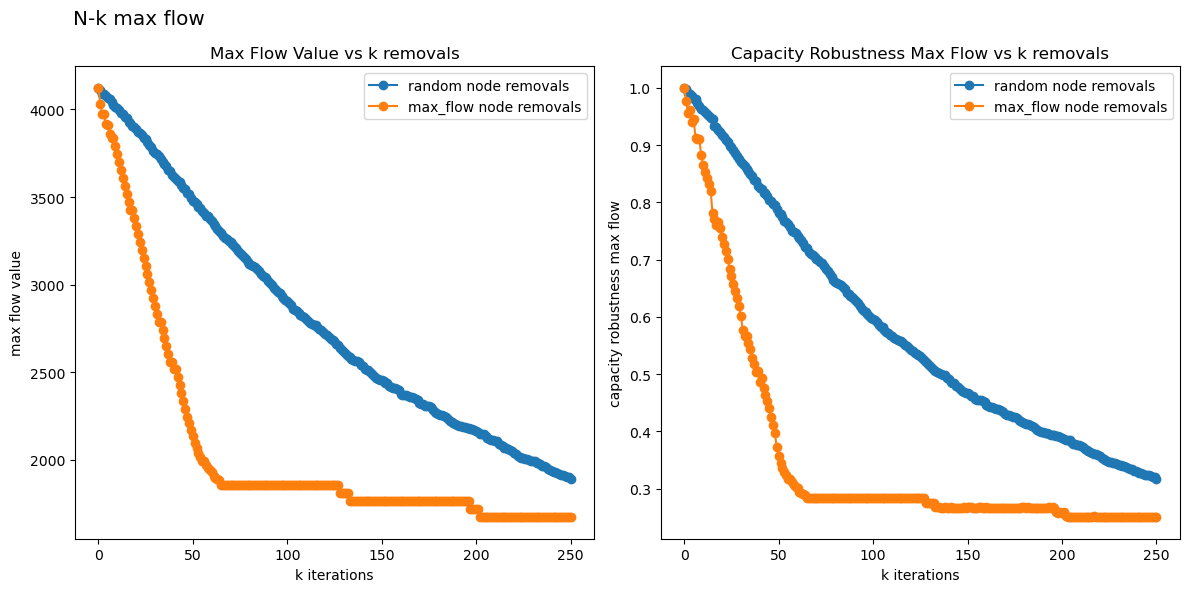

In [12]:
utils.plot_heuristic_comparison_biplot([random_node_removal_df,  max_flow_node_removal_df], 'N-k max flow')

### Edge removal ('sinks-to-sources')

In [14]:
# random_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='random', remove='edge')
# random_edge_removal_df.to_pickle('results/random_edge_removal_df.pkl')
random_edge_removal_df = pd.read_pickle('results/max_flow/random_edge_removal_df.pkl')

In [15]:
""" load_rate_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='edge')
load_rate_edge_removal_df.to_pickle('results/max_flow/load_rate_edge_removal_df.pkl')
load_rate_edge_removal_df = pd.read_pickle('results/max_flow/load_rate_edge_removal_df.pkl')
utils.results_summary(load_rate_edge_removal_df) """

" load_rate_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='edge')\nload_rate_edge_removal_df.to_pickle('results/max_flow/load_rate_edge_removal_df.pkl')\nload_rate_edge_removal_df = pd.read_pickle('results/max_flow/load_rate_edge_removal_df.pkl')\nutils.results_summary(load_rate_edge_removal_df) "

In [16]:
# max_flow_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow', remove='edge')
# max_flow_edge_removal_df.to_pickle('results/max_flow/max_flow_edge_removal_df.pkl')
max_flow_edge_removal_df = pd.read_pickle('results/max_flow/max_flow_edge_removal_df.pkl')
utils.results_summary(max_flow_edge_removal_df)

Heuristic: max_flow

First entity removals:
----------------------------------------------
 it             removed_entity  diff  pct_change
  1  {INET_N_1630, INET_N_301} 90.41        -2.2
  2 {INET_N_1258, INET_N_1334} 45.51        -1.1
  3  {INET_N_1240, INET_N_536} 60.27        -1.5
  4     {NO_N_27, INET_N_1599}  0.00        -0.0
  5   {INET_N_752, INET_N_952} 54.79        -1.4

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it             removed_entity  diff  pct_change
  1  {INET_N_1630, INET_N_301} 90.41        -2.2
  3  {INET_N_1240, INET_N_536} 60.27        -1.5
  5   {INET_N_752, INET_N_952} 54.79        -1.4
  7   {INET_N_889, INET_N_435} 54.79        -1.4
  2 {INET_N_1258, INET_N_1334} 45.51        -1.1


Summary statistics (first 250 removals)
----------------------------------------------
Percentage network damage: 53.9%
Mean damage per entity removal: 61.15
Variation in damage per entity removal: 17.19


In [17]:
""" max_flow_edge_count_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_count', remove='edge')
max_flow_edge_count_edge_removal_df.to_pickle('results/max_flow/max_flow_edge_count_edge_removal_df.pkl')
max_flow_edge_count_edge_removal_df = pd.read_pickle('results/max_flow/max_flow_edge_count_edge_removal_df.pkl')
utils.results_summary(max_flow_edge_count_edge_removal_df) """

" max_flow_edge_count_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_count', remove='edge')\nmax_flow_edge_count_edge_removal_df.to_pickle('results/max_flow/max_flow_edge_count_edge_removal_df.pkl')\nmax_flow_edge_count_edge_removal_df = pd.read_pickle('results/max_flow/max_flow_edge_count_edge_removal_df.pkl')\nutils.results_summary(max_flow_edge_count_edge_removal_df) "

In [18]:
""" max_flow_edge_flows_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_flows', remove='edge')
max_flow_edge_flows_edge_removal_df.to_pickle('results/max_flow/max_flow_edge_flows_edge_removal_df.pkl')
max_flow_edge_flows_edge_removal_df = pd.read_pickle('results/max_flow/max_flow_edge_flows_edge_removal_df.pkl')
utils.results_summary(max_flow_edge_flows_edge_removal_df) """

" max_flow_edge_flows_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_flows', remove='edge')\nmax_flow_edge_flows_edge_removal_df.to_pickle('results/max_flow/max_flow_edge_flows_edge_removal_df.pkl')\nmax_flow_edge_flows_edge_removal_df = pd.read_pickle('results/max_flow/max_flow_edge_flows_edge_removal_df.pkl')\nutils.results_summary(max_flow_edge_flows_edge_removal_df) "

In [19]:
""" wfcr_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='wfcr', remove='edge')
wfcr_edge_removal_df.to_pickle('results/max_flow/wfcr_edge_removal_df.pkl')
wfcr_edge_removal_df = pd.read_pickle('results/max_flow/wfcr_edge_removal_df.pkl')
utils.results_summary(wfcr_edge_removal_df) """

" wfcr_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='wfcr', remove='edge')\nwfcr_edge_removal_df.to_pickle('results/max_flow/wfcr_edge_removal_df.pkl')\nwfcr_edge_removal_df = pd.read_pickle('results/max_flow/wfcr_edge_removal_df.pkl')\nutils.results_summary(wfcr_edge_removal_df) "

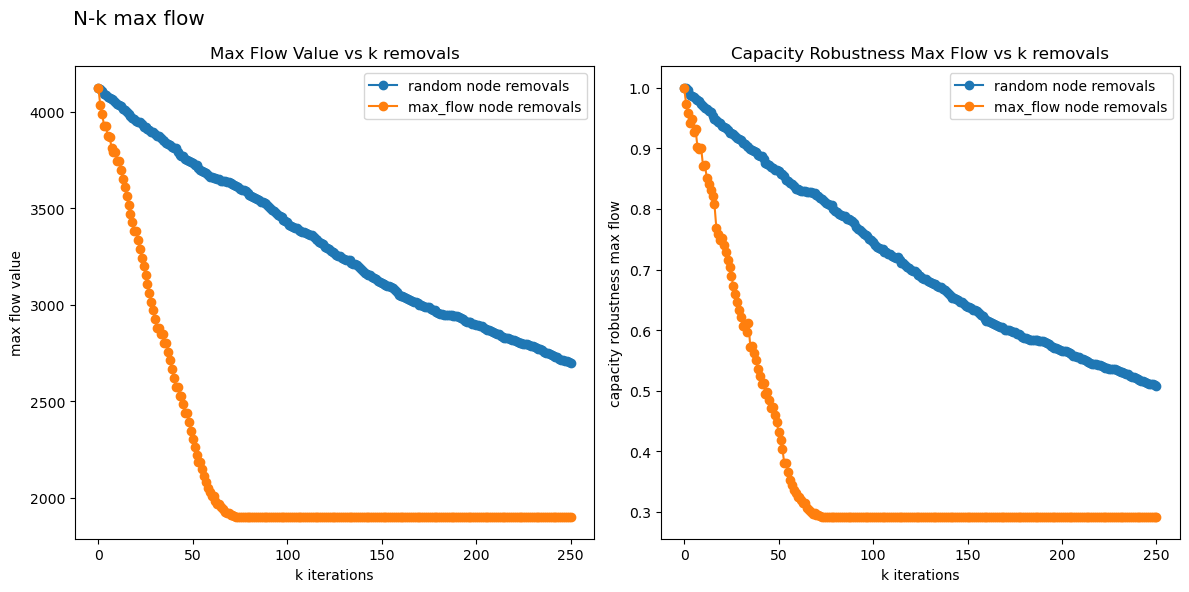

In [20]:
utils.plot_heuristic_comparison_biplot([random_edge_removal_df, max_flow_edge_removal_df], 'N-k max flow')